## 1. Setup and Data Loading

In [1]:
# Load data, drop duration (leakage), and create reusable train/test split for Q3

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, precision_recall_fscore_support, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Load dataset and perform initial cleaning
df = pd.read_csv('Data/bank-additional-full.csv', sep=';')
df = df.drop(columns=['duration'])  # Remove duration to avoid data leakage
y = (df['y'] == 'yes').astype(int)
X = df.drop(columns=['y'])

# Create global train-test split for consistent evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Data loaded and split.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Data loaded and split.
Training set shape: (32950, 19)
Test set shape: (8238, 19)


## 2. Automated Feature Selection Techniques

This section explores various automated methods to identify the most predictive features, excluding the `duration` column to prevent data leakage.

### 2.1 Correlation Analysis (Numeric Features)

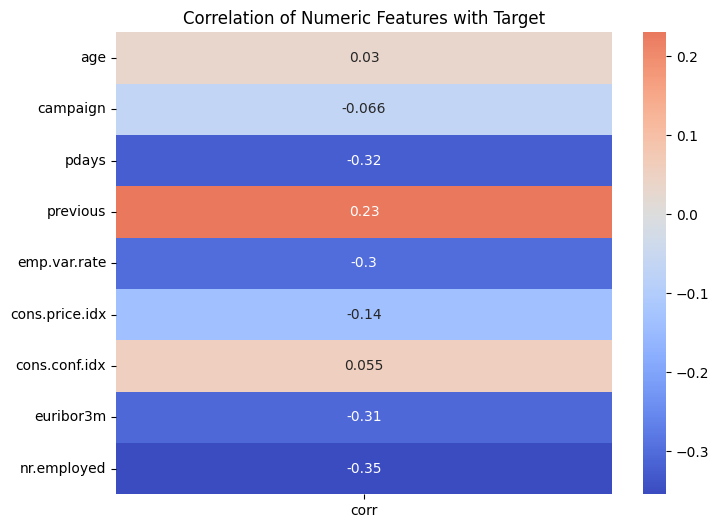

In [26]:
# Correlate numeric features with target to spot strongest signals (EDA)

num_cols = X.select_dtypes(exclude=['object']).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corrwith(y).to_frame('corr'), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Numeric Features with Target')
plt.show()

### 2.2 Mutual Information

In [27]:
# Mutual information on one-hot encoded features to rank importance (cats+nums)

mi_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_mi = mi_encoder.fit_transform(X)
feature_names_mi = mi_encoder.get_feature_names_out()
mi_scores = mutual_info_classif(X_mi, y, discrete_features=True, random_state=42)
mi_df = pd.DataFrame({'feature': feature_names_mi, 'mi': mi_scores}).sort_values('mi', ascending=False)
print("Top 10 Features by Mutual Information:")
mi_df.head(10)

Top 10 Features by Mutual Information:


,feature,mi
196,pdays_999,0.030834
207,poutcome_success,0.028978
197,previous_0,0.015001
206,poutcome_nonexistent,0.015001
596,nr.employed_5228.1,0.012550
217,emp.var.rate_1.4,0.012550
112,contact_telephone,0.011646
111,contact_cellular,0.011646
236,cons.price.idx_93.994,0.009957
260,cons.conf.idx_-36.4,0.009957


### 2.3 Random Forest Feature Importance

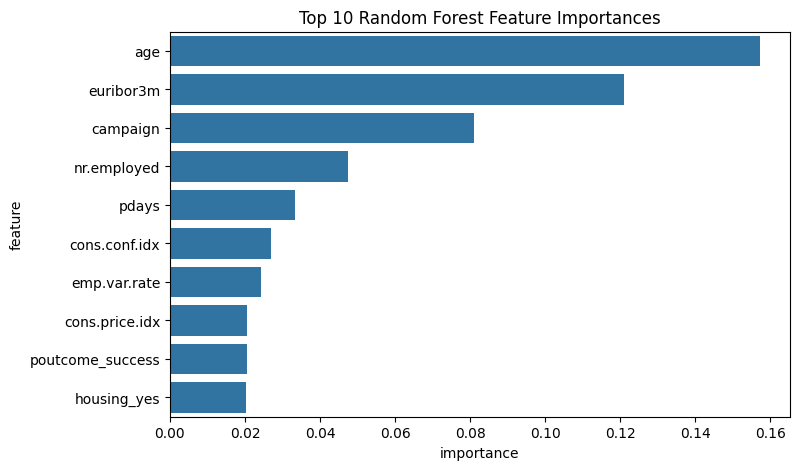

In [28]:
# Random Forest with preprocessing to gauge feature importances (OHE + scaled nums)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

preprocess_rf = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

rf_pipeline = Pipeline([
    ('pre', preprocess_rf),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)

ct_rf = rf_pipeline.named_steps['pre']
cat_features_out_rf = ct_rf.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features_rf = num_cols + list(cat_features_out_rf)
importances_rf = rf_pipeline.named_steps['clf'].feature_importances_
imp_df_rf = pd.DataFrame({'feature': all_features_rf, 'importance': importances_rf}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df_rf.head(10), x='importance', y='feature')
plt.title('Top 10 Random Forest Feature Importances')
plt.show()

### 2.4 Recursive Feature Elimination (RFE)

In [29]:
# RFE with logistic regression to pick a leak-free top-7 feature set

log_rfe = LogisticRegression(max_iter=1000)
rfe = RFE(log_rfe, n_features_to_select=7, step=0.1)
rfe.fit(mi_encoder.transform(X), y)
selected_rfe = [feature_names_mi[i] for i, sel in enumerate(rfe.support_) if sel]
print("Top 7 Features Selected by RFE:")
selected_rfe

Top 7 Features Selected by RFE:


['euribor3m_0.697',
 'euribor3m_0.87',
 'euribor3m_4.021',
 'euribor3m_4.076',
 'euribor3m_4.12',
 'euribor3m_4.153',
 'euribor3m_4.191']

### 2.5 Gradient Boosting Feature Importance

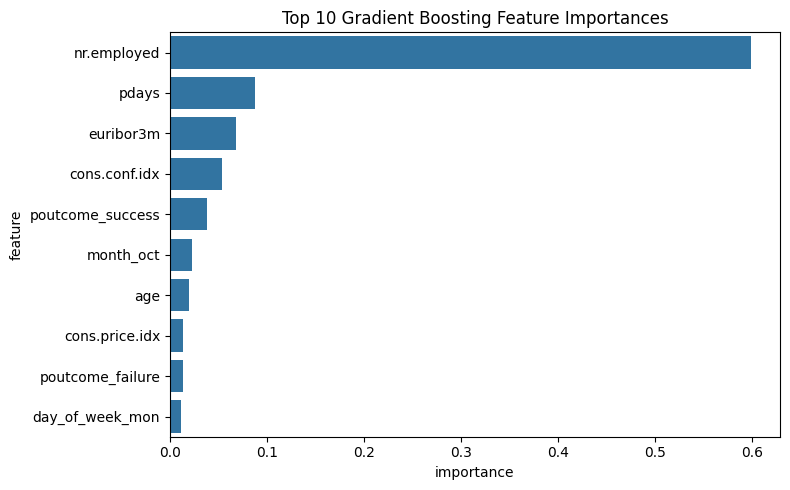

In [30]:
# Gradient Boosting with preprocessing to compare importances vs RF/RFE

pre_gb = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

gb_pipeline = Pipeline([
    ('pre', pre_gb),
    ('clf', GradientBoostingClassifier(random_state=42))
])

gb_pipeline.fit(X_train, y_train)
ct_gb = gb_pipeline.named_steps['pre']
cat_features_out_gb = ct_gb.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features_gb = num_cols + list(cat_features_out_gb)
importances_gb = gb_pipeline.named_steps['clf'].feature_importances_
imp_df_gb = pd.DataFrame({'feature': all_features_gb, 'importance': importances_gb}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df_gb.head(10), x='importance', y='feature')
plt.title('Top 10 Gradient Boosting Feature Importances')
plt.tight_layout()
plt.show()

### 2.6 Principal Component Analysis (PCA)

Explained variance ratio by top 2 PCs: [0.43262262 0.15072846]


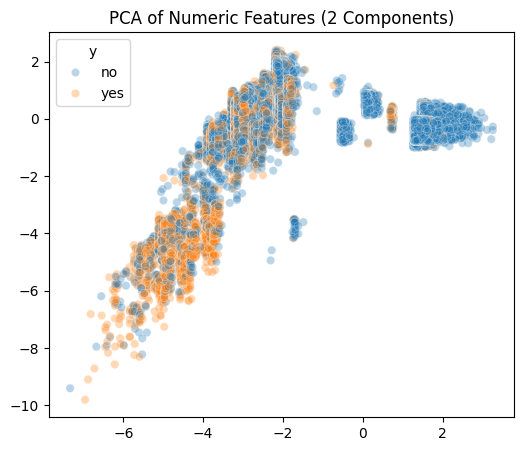

In [31]:
# PCA on numeric features to view variance structure and class separation

scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(df[num_cols])
pca = PCA(n_components=2, random_state=42)
pca_vals = pca.fit_transform(X_scaled_pca)
print('Explained variance ratio by top 2 PCs:', pca.explained_variance_ratio_)
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca_vals[:,0], y=pca_vals[:,1], hue=df['y'], alpha=0.3)
plt.title('PCA of Numeric Features (2 Components)')
plt.show()

## 3. Feature Selection Summary & Final Selection

Based on the automated analyses, several features consistently rank as important:

- **Macro-economic indicators**: `nr.employed`, `euribor3m`, and `emp.var.rate` show strong correlation and high importance in tree-based models.
- **Campaign history**: `pdays` (especially the value 999, indicating no previous contact) and `poutcome` are significant.
- **Client attributes**: `age` and `campaign` (number of contacts) are consistently important.

**Final Selection:**
A set of 7 features is manually selected to balance predictive power, interpretability, and diversity of information without including the `duration` leak feature.

**Selected Features**: `euribor3m`, `age`, `campaign`, `nr.employed`, `pdays`, `emp.var.rate`, `cons.conf.idx`

## 4. Model Benchmarking with Selected Features

This section benchmarks four different classification models using the manually selected top 7 leak-free features. Each model is evaluated on its AUC score, and a detailed classification report and confusion matrix are provided.


### 4.1 Logistic Regression


Logistic Regression AUC: 0.7752
              precision    recall  f1-score   support

           0      0.956     0.730     0.827      7310
           1      0.256     0.733     0.379       928

    accuracy                          0.730      8238
   macro avg      0.606     0.731     0.603      8238
weighted avg      0.877     0.730     0.777      8238



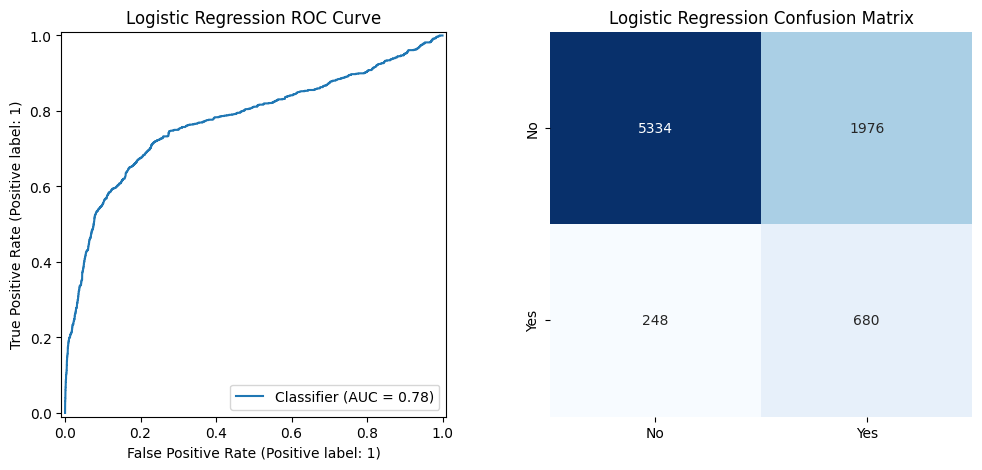

In [2]:
# Logistic regression (balanced) on curated top-7 leak-free features

feat_top7 = ['euribor3m','age','campaign','nr.employed','pdays','emp.var.rate','cons.conf.idx']
X_top7 = df[feat_top7]
X_train_top7, X_test_top7, y_train_top7, y_test_top7 = train_test_split(X_top7, y, test_size=0.2, stratify=y, random_state=42)

log_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
log_pipe.fit(X_train_top7, y_train_top7)
log_probs = log_pipe.predict_proba(X_test_top7)[:,1]
log_preds = (log_probs >= 0.5).astype(int)
auc_log = roc_auc_score(y_test_top7, log_probs)

print(f"Logistic Regression AUC: {auc_log:.4f}")
print(classification_report(y_test_top7, log_preds, digits=3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test_top7, log_probs, ax=ax1)
ax1.set_title('Logistic Regression ROC Curve')
cm_log = confusion_matrix(y_test_top7, log_preds)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax2.set_title('Logistic Regression Confusion Matrix')
plt.show()

### 4.2 K-Nearest Neighbors (KNN)


KNN AUC: 0.7182
              precision    recall  f1-score   support

           0      0.918     0.945     0.931      7310
           1      0.434     0.332     0.376       928

    accuracy                          0.876      8238
   macro avg      0.676     0.638     0.654      8238
weighted avg      0.863     0.876     0.869      8238



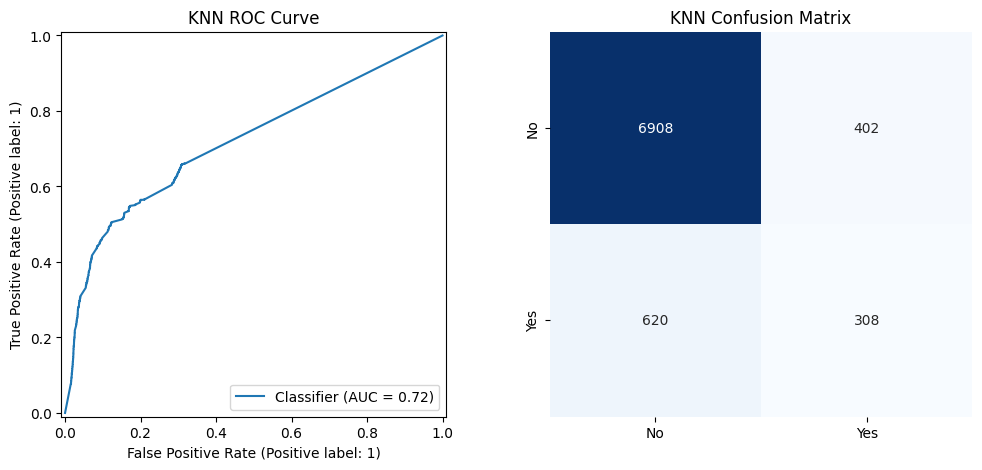

In [3]:
# KNN baseline on top-7 features for comparison

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=10, weights='distance'))
])
knn_pipe.fit(X_train_top7, y_train_top7)
knn_probs = knn_pipe.predict_proba(X_test_top7)[:,1]
knn_preds = (knn_probs >= 0.5).astype(int)
auc_knn = roc_auc_score(y_test_top7, knn_probs)

print(f"KNN AUC: {auc_knn:.4f}")
print(classification_report(y_test_top7, knn_preds, digits=3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test_top7, knn_probs, ax=ax1)
ax1.set_title('KNN ROC Curve')
cm_knn = confusion_matrix(y_test_top7, knn_preds)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax2.set_title('KNN Confusion Matrix')
plt.show()

### 4.3 Decision Tree


Decision Tree AUC: 0.8025
              precision    recall  f1-score   support

           0      0.948     0.906     0.926      7310
           1      0.450     0.608     0.517       928

    accuracy                          0.872      8238
   macro avg      0.699     0.757     0.722      8238
weighted avg      0.892     0.872     0.880      8238



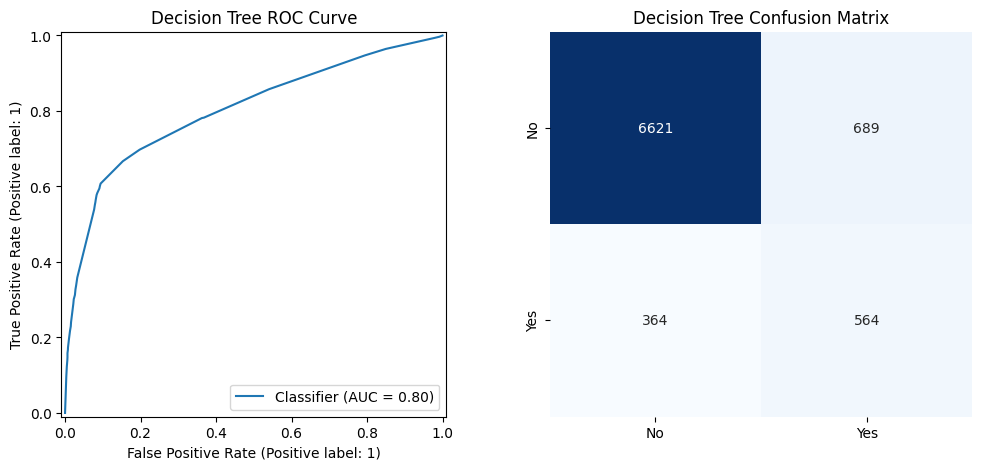

In [4]:
# Shallow balanced decision tree on top-7 features

tree_pipe = Pipeline([
    ('scaler', StandardScaler()), # Although not strictly necessary for trees, it doesn't hurt
    ('clf', DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, random_state=42, class_weight='balanced'))
])
tree_pipe.fit(X_train_top7, y_train_top7)
tree_probs = tree_pipe.predict_proba(X_test_top7)[:,1]
tree_preds = (tree_probs >= 0.5).astype(int)
auc_tree = roc_auc_score(y_test_top7, tree_probs)

print(f"Decision Tree AUC: {auc_tree:.4f}")
print(classification_report(y_test_top7, tree_preds, digits=3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test_top7, tree_probs, ax=ax1)
ax1.set_title('Decision Tree ROC Curve')
cm_tree = confusion_matrix(y_test_top7, tree_preds)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax2.set_title('Decision Tree Confusion Matrix')
plt.show()

In [ ]:
# Visualize decision tree (top 3 levels) to show key splits

# Visualize the Decision Tree structure
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(tree_pipe.named_steps['clf'], 
          feature_names=feat_top7,
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Show only top 3 levels for readability
plt.title('Decision Tree Visualization (Top 3 Levels)', fontsize=16)
plt.tight_layout()
plt.show()

### 4.4 Gaussian Naive Bayes


Gaussian Naive Bayes AUC: 0.7791
              precision    recall  f1-score   support

           0      0.935     0.925     0.930      7310
           1      0.457     0.496     0.476       928

    accuracy                          0.877      8238
   macro avg      0.696     0.710     0.703      8238
weighted avg      0.881     0.877     0.879      8238



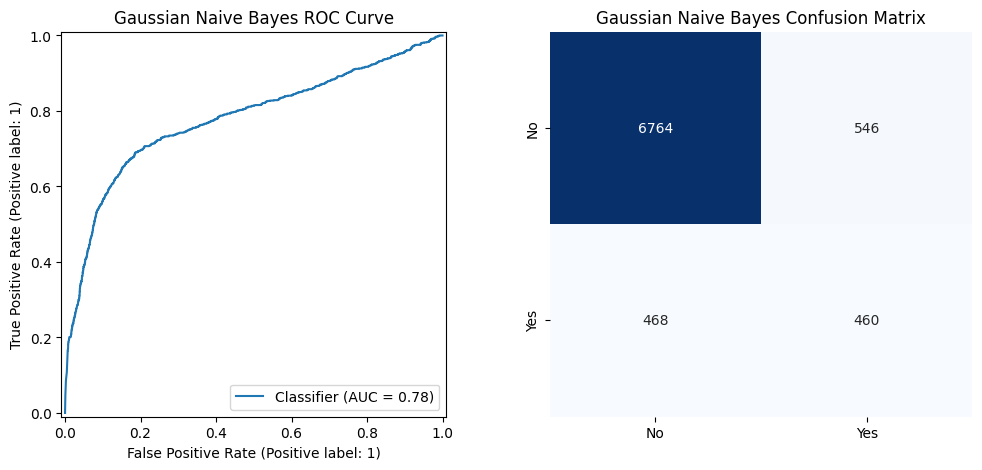

In [5]:
# Gaussian Naive Bayes baseline on top-7 features

nb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GaussianNB())
])
nb_pipe.fit(X_train_top7, y_train_top7)
nb_probs = nb_pipe.predict_proba(X_test_top7)[:,1]
nb_preds = (nb_probs >= 0.5).astype(int)
auc_nb = roc_auc_score(y_test_top7, nb_probs)

print(f"Gaussian Naive Bayes AUC: {auc_nb:.4f}")
print(classification_report(y_test_top7, nb_preds, digits=3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test_top7, nb_probs, ax=ax1)
ax1.set_title('Gaussian Naive Bayes ROC Curve')
cm_nb = confusion_matrix(y_test_top7, nb_preds)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax2.set_title('Gaussian Naive Bayes Confusion Matrix')
plt.show()

## 5. Model Comparison and Final Conclusion


### A Note on Metrics: Precision vs. Recall

For this business problem, **recall is generally the more important metric.** Here's why:

- **Recall (Sensitivity):** Answers "Of all the clients who would have actually subscribed, how many did our model correctly identify?"
  - **Business Impact:** A high recall ensures you are finding the maximum number of potential customers. A **low recall is very costly** because every missed "yes" is lost revenue. The cost of a False Negative (missing a sale) is much higher than the cost of a False Positive.

- **Precision:** Answers "Of all the clients we predicted would subscribe, how many actually did?"
  - **Business Impact:** A high precision means your marketing efforts are very efficient. A **low precision is inefficient**, as you waste resources contacting clients who are not interested.

**Conclusion for this problem:** The primary goal is to avoid missing potential sales. Therefore, we prioritize **recall**. We want to identify as many true "yes" clients as possible, even if it means contacting some "no" clients by mistake. The model's threshold can be tuned to find an acceptable balance between maximizing recall and maintaining reasonable precision.


In [6]:
# Aggregate metrics across models and print conclusions

from sklearn.metrics import precision_score

results = {
    'Logistic Regression': {
        'AUC': auc_log,
        'Recall': recall_score(y_test_top7, log_preds),
        'Precision': precision_score(y_test_top7, log_preds)
    },
    'K-Nearest Neighbors': {
        'AUC': auc_knn,
        'Recall': recall_score(y_test_top7, knn_preds),
        'Precision': precision_score(y_test_top7, knn_preds)
    },
    'Decision Tree': {
        'AUC': auc_tree,
        'Recall': recall_score(y_test_top7, tree_preds),
        'Precision': precision_score(y_test_top7, tree_preds)
    },
    'Gaussian Naive Bayes': {
        'AUC': auc_nb,
        'Recall': recall_score(y_test_top7, nb_preds),
        'Precision': precision_score(y_test_top7, nb_preds)
    }
}

results_df = pd.DataFrame.from_dict(results, orient='index').sort_values('Recall', ascending=False)

print("--- Model Comparison (Metrics on Top 7 Features) ---")
print(results_df)

print("\n--- Final Conclusion ---")
print("After removing the `duration` feature to prevent data leakage, a combination of automated feature selection techniques consistently highlighted the importance of macro-economic indicators, campaign history, and client attributes.")
print("A manually selected set of the top 7 leak-free features was used to benchmark four different classifiers.")
print(f"\nWhen prioritizing RECALL to minimize missed sales, the best performing model is {results_df.index[0]} with a Recall of {results_df.iloc[0,1]:.4f}.")
print(f"When prioritizing overall predictive power (AUC), the best performing model is {results_df.sort_values('AUC', ascending=False).index[0]} with an AUC of {results_df.sort_values('AUC', ascending=False).iloc[0,0]:.4f}.")
print("\nBy balancing class weights where applicable, the models are able to identify a meaningful number of positive cases while maintaining reasonable precision.")

--- Model Comparison (Metrics on Top 7 Features) ---
                           AUC    Recall  Precision
Logistic Regression   0.775225  0.732759   0.256024
Decision Tree         0.802505  0.607759   0.450120
Gaussian Naive Bayes  0.779115  0.495690   0.457256
K-Nearest Neighbors   0.718150  0.331897   0.433803

--- Final Conclusion ---
After removing the `duration` feature to prevent data leakage, a combination of automated feature selection techniques consistently highlighted the importance of macro-economic indicators, campaign history, and client attributes.
A manually selected set of the top 7 leak-free features was used to benchmark four different classifiers.

When prioritizing RECALL to minimize missed sales, the best performing model is Logistic Regression with a Recall of 0.7328.
When prioritizing overall predictive power (AUC), the best performing model is Decision Tree with an AUC of 0.8025.

By balancing class weights where applicable, the models are able to identify a mea

In [37]:
# Duplicate aggregate metrics block (kept for quick reruns/logging)

from sklearn.metrics import precision_score

results = {
    'Logistic Regression': {
        'AUC': auc_log,
        'Recall': recall_score(y_test_top7, log_preds),
        'Precision': precision_score(y_test_top7, log_preds)
    },
    'K-Nearest Neighbors': {
        'AUC': auc_knn,
        'Recall': recall_score(y_test_top7, knn_preds),
        'Precision': precision_score(y_test_top7, knn_preds)
    },
    'Decision Tree': {
        'AUC': auc_tree,
        'Recall': recall_score(y_test_top7, tree_preds),
        'Precision': precision_score(y_test_top7, tree_preds)
    },
    'Gaussian Naive Bayes': {
        'AUC': auc_nb,
        'Recall': recall_score(y_test_top7, nb_preds),
        'Precision': precision_score(y_test_top7, nb_preds)
    }
}

results_df = pd.DataFrame.from_dict(results, orient='index').sort_values('Recall', ascending=False)

print("--- Model Comparison (Metrics on Top 7 Features) ---")
print(results_df)

print("\n--- Final Conclusion ---")
print("After removing the `duration` feature to prevent data leakage, a combination of automated feature selection techniques consistently highlighted the importance of macro-economic indicators, campaign history, and client attributes.")
print("A manually selected set of the top 7 leak-free features was used to benchmark four different classifiers.")
print(f"\nWhen prioritizing RECALL to minimize missed sales, the best performing model is {results_df.index[0]} with a Recall of {results_df.iloc[0,1]:.4f}.")
print(f"When prioritizing overall predictive power (AUC), the best performing model is {results_df.sort_values('AUC', ascending=False).index[0]} with an AUC of {results_df.sort_values('AUC', ascending=False).iloc[0,0]:.4f}.")
print("\nBy balancing class weights where applicable, the models are able to identify a meaningful number of positive cases while maintaining reasonable precision.")

--- Model Comparison (Metrics on Top 7 Features) ---
                           AUC    Recall  Precision
Logistic Regression   0.775225  0.732759   0.256024
Decision Tree         0.802505  0.607759   0.450120
Gaussian Naive Bayes  0.779115  0.495690   0.457256
K-Nearest Neighbors   0.718150  0.331897   0.433803

--- Final Conclusion ---
After removing the `duration` feature to prevent data leakage, a combination of automated feature selection techniques consistently highlighted the importance of macro-economic indicators, campaign history, and client attributes.
A manually selected set of the top 7 leak-free features was used to benchmark four different classifiers.

When prioritizing RECALL to minimize missed sales, the best performing model is Logistic Regression with a Recall of 0.7328.
When prioritizing overall predictive power (AUC), the best performing model is Decision Tree with an AUC of 0.8025.

By balancing class weights where applicable, the models are able to identify a mea